**Tutorial 7 - Regression, prediction, k-fold validation**

In this tutorial we will get some practice with the skilearn package, do some linear modeling of QSO data

1) 

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pa

1) Import the data from the file SDSS_QSO.dat.  This file constains data on QSO's.  It has the name, redshift, photomatry in 5 bands and errors, the brightness in the X-ray, and brightness in radio.

Further information on columns:
FIRST - brightness in radio in magnitudes, 0 is undetected, -1 not observed
ROSAT - X-ray brightness in log(counts), -9 not detected

In [130]:
data = pa.read_csv("SDSS_QSO.dat",sep='\s+',comment='#')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77429 entries, 0 to 77428
Data columns (total 15 columns):
SDSS         77429 non-null object
z            77429 non-null float64
u_mag        77429 non-null float64
sig_u_mag    77429 non-null float64
g_mag        77429 non-null float64
sig_g_mag    77429 non-null float64
r_mag        77429 non-null float64
sig_r_mag    77429 non-null float64
i_mag        77429 non-null float64
sig_i_mag    77429 non-null float64
z_mag        77429 non-null float64
sig_z_mag    77429 non-null float64
FIRST        77429 non-null float64
ROSAT        77429 non-null float64
Mp           77429 non-null float64
dtypes: float64(14), object(1)
memory usage: 8.9+ MB


2) Make numpy vectors of the 5 bands.  Then put these into a block that is shape [n_bands,n_qso].  Also make a vector of the redshifts.

In [195]:
mag_u = np.array(data['u_mag'])
mag_g = np.array(data['g_mag'])
mag_r = np.array(data['r_mag'])
mag_i = np.array(data['i_mag'])
mag_z = np.array(data['z_mag'])

ug = mag_u - mag_g
ur = mag_u - mag_r
ui = mag_u - mag_i
uz = mag_u - mag_z
gr = mag_g - mag_r
gi = mag_g - mag_i
gz = mag_g - mag_z
ri = mag_r - mag_i
rz = mag_r - mag_z
iz = mag_i - mag_z

#color_block = np.array( [ug,ur,ui,uz,gr,gi,gz,ri,rz,iz] )
color_block = np.array( [mag_u,mag_g,mag_r,mag_i,mag_z] )
redshift = np.array(data['z'])

3) From sklearn import linear_model.  Make a linear_model.LinearRegression() object 
and then fit a model that predicts redshifts from the colors. (see https://scikit-learn.org/stable/modules/linear_model.html for more information.)  Print out the coefficients.  Use the model.score() function to give the score for the model which in this case is the R^2 statistice (coefficient of determination).

In [196]:
from sklearn import linear_model

l_mod = linear_model.LinearRegression()
l_mod.fit(color_block.T,redshift)

print l_mod.coef_
print "score = ",l_mod.score(color_block.T,redshift)


[ 0.53634995 -0.19411789  0.28510409 -0.89250146  0.34220655]
score =  0.4280207488458053


4) Use the model to predict the redshifts for all of the QSOs.  Make a scatter plot of the predicted vs observed redshifts. Decreasing the alpha parameters can make this clearer.

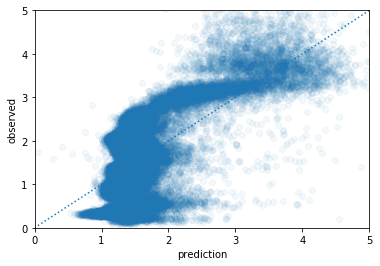

In [204]:

y = l_mod.predict(color_block.T)

plt.scatter(y,redshift,alpha=0.05)
plt.plot([0,5],[0,5],linestyle=':')
plt.ylabel("observed")
plt.xlabel("prediction")
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()


5) Do a k-fold validation with k=10 using sklearn.model_selection.KFold. Make an array of the MSE's for each resampling.  Make a histagram of the square root of the MSE's divided by the standard deviation of the redshifts.  This is a measure of how well the prediction model works compared to randomly sampling from the redshift distribution.

k =  10


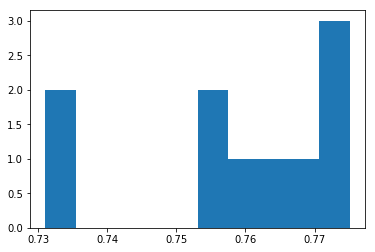

In [198]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=10)
### print k
print 'k = ',kf.get_n_splits()

mean_mse = np.zeros(kf.get_n_splits())
j = 0
for train_index, test_index in kf.split(redshift):
    #print "TRAIN:", train_index, "TEST:", test_index
    X_train, X_test = color_block.T[train_index], color_block.T[test_index]
    Y_train, Y_test = redshift[train_index], redshift[test_index]
        
    ## fit model
    l_mod.fit(X_train,Y_train)
    y_pred = l_mod.predict(X_test)
       
    mean_mse[j] = mean_squared_error(Y_test,y_pred)
    j += 1
        
#mse_array[i] = np.sqrt( mean_mse/kf.get_n_splits(x) )
mse_array = np.median( mean_mse )
mse_std = np.sqrt( mean_mse )/np.std(redshift)
plt.hist(mse_std)
plt.show()

6) Do ridge regression on the same data. The strength of the prior is controled by the alpha parameter.  linear_model.RidgeCV() will automatically select an alpha from the ones provided by doing cross-validation for each one and taking the one with the best MSE. Use alphas=[0.1, 1.0, 10.0, 100.0,1000.0] and cv=5.  What is the best alpha? Print out the coeficients.  Print the score.  Make a scatter plot of the predictions vs the observed redshifts.

best alpha =  100.0
coeficiants =  [ 0.53109617 -0.16997205  0.21203911 -0.79094256  0.29563934]
score =  0.4277979898206397


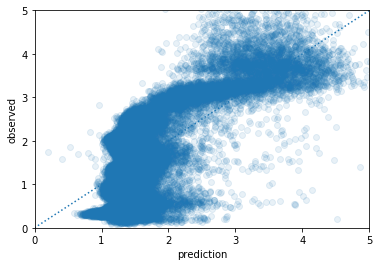

In [199]:
reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0,1000.0], cv=5)
reg.fit(color_block.T,redshift)

print "best alpha = ",reg.alpha_
print "coeficiants = ",reg.coef_
print "score = ",reg.score(color_block.T,redshift)

y = reg.predict(color_block.T)

plt.scatter(y,redshift,alpha=0.1)
plt.plot([0,5],[0,5],linestyle=':')
plt.ylabel("observed")
plt.xlabel("prediction")
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

7) Do LASSO regression using linear_model.LassoCV() and output the same thing as for ridge regression.  Which single color best pridcts the redshift.

best alpha =  0.1
coeficiants =  [ 0.29203342 -0.         -0.         -0.10565226 -0.        ]
score =  0.3445992404033651


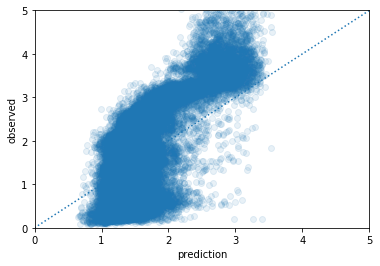

In [200]:
lasso = linear_model.LassoCV(alphas=[0.1, 1.0, 10.0, 100.0,1000.0], cv=5)

lasso.fit(color_block.T,redshift)

print "best alpha = ",lasso.alpha_
print "coeficiants = ",lasso.coef_
print "score = ",lasso.score(color_block.T,redshift)
y = lasso.predict(color_block.T)

plt.scatter(y,redshift,alpha=0.1)
plt.plot([0,5],[0,5],linestyle=':')
plt.ylabel("observed")
plt.xlabel("prediction")
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

8) Let's include terms that are higher order in the colors.  Use the function 
PolynomialFeatures(3).fit_transform() to extend the color matrix to one with extra columns that have powers and products of the existing columns up to third order.
Then train the ridge regression model found above using this feature matrix.
What is the score for this model?

In [205]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3).fit_transform(color_block.T)

reg.fit(poly,redshift)

print reg.coef_
print "score = ",reg.score(poly,redshift)

[ 0.         -0.04875214 -0.05522609 -0.05093591 -0.05115303 -0.04779988
  0.01662838 -0.00854347  0.02762395  0.03008904  0.06533391 -0.09527257
 -0.03743384 -0.04591893  0.00818508  0.00597945 -0.00729589  0.03642936
 -0.03338148  0.0165012   0.03843526 -0.00333413 -0.05626492  0.14831685
 -0.07148488 -0.01375671  0.02313652  0.07252963  0.05560456 -0.03271208
 -0.09755802 -0.06964711 -0.18951644  0.10554984  0.007357    0.11625231
 -0.02253454  0.01620459  0.07059241 -0.03930805  0.02117096 -0.05069276
 -0.07445192 -0.10238738 -0.03909317  0.1442316  -0.00026611  0.00596666
  0.0576946   0.0334785   0.1184192   0.02449168 -0.0379291   0.03605963
 -0.05761057 -0.09877134]
score =  0.5348058980658996


9) Plot the predicted vs the observed redshifts for this model.

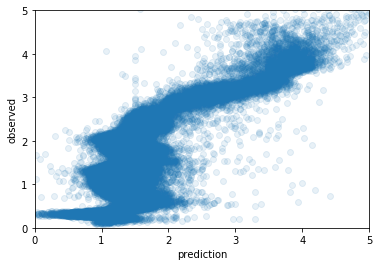

In [202]:
y_plot = reg.predict(poly)

plt.scatter(y_plot,redshift,alpha=0.1)
plt.ylabel("observed")
plt.xlabel("prediction")
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()